### Using the Mauna Lua CO2 dataset (monthly) perform forecasting using an MLP and compare the results with that of MA (Moving Average) and ARMA (Auto Regressive Moving Average) models. Main setting: use previous “K” readings to predict next “T” reading. Example, if “K=3” and “T=1” then we use data from Jan, Feb, March and then predict the reading for April. Comment on why you observe such results. For MA or ARMA you can use any library or implement it from scratch. The choice of MLP is up to you. **[2 marks]**

Importing Libraries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader



if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Supported Device: {device}")

Supported Device: cpu


Loading the data

Mauna Lua CO2 Dataset - https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv

In [2]:
df = pd.read_csv('co2_mm_mlo.csv')
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
787,2023,10,2023.7917,418.82,422.12,27,0.47,0.17
788,2023,11,2023.8750,420.46,422.46,21,0.91,0.38
789,2023,12,2023.9583,421.86,422.58,20,0.68,0.29
790,2024,1,2024.0417,422.80,422.45,27,0.73,0.27


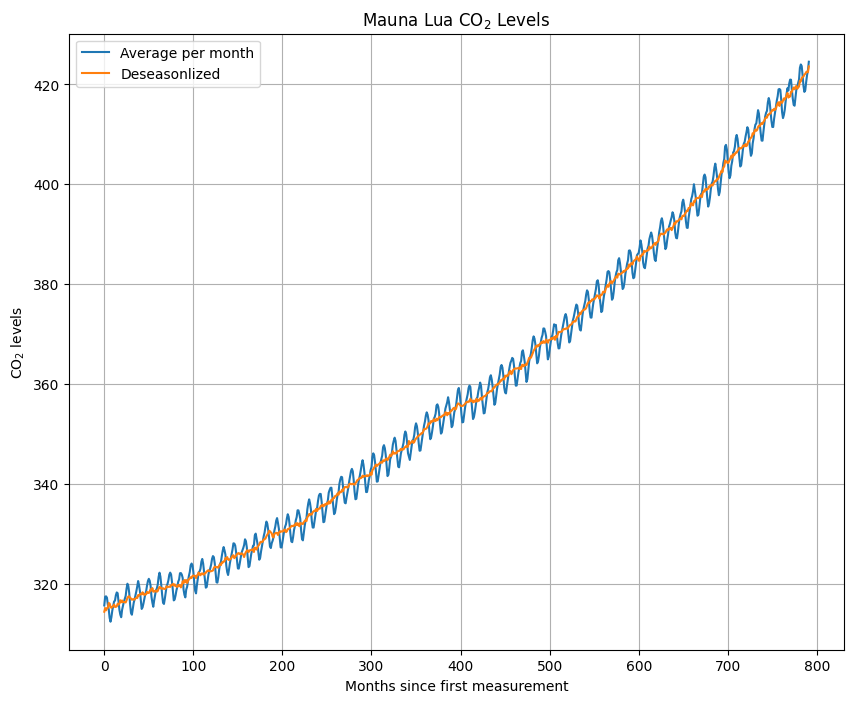

In [6]:
fig = plt.figure(figsize=(10,8))
plt.title(r'Mauna Lua CO$_2$ Levels')
plt.plot(df.index, df['average'])
plt.plot(df.index, df['deseasonalized'])
plt.xlabel('Months since first measurement')
plt.ylabel(r'CO$_2$ levels')
plt.grid()
plt.legend(['Average per month', 'Deseasonlized'])
plt.show()

Creating features

![Dataset](data.png)
<br>L = Number of Samples
<br>K = Window Size 

In [20]:
scaler = StandardScaler().fit(df['average'].values.reshape(-1,1))
scaled_D = scaler.transform(df['average'].values.reshape(-1,1))
scaled_D.shape, scaled_D

((792, 1),
 array([[-1.3721661 ],
        [-1.31653778],
        [-1.31463052],
        [-1.32321318],
        [-1.36708008],
        [-1.39664256],
        [-1.45163513],
        [-1.4761116 ],
        [-1.44750274],
        [-1.40490734],
        [-1.37598061],
        [-1.34737176],
        [-1.34196787],
        [-1.30795512],
        [-1.28983618],
        [-1.29428645],
        [-1.34546451],
        [-1.40077495],
        [-1.43129106],
        [-1.44750274],
        [-1.40045708],
        [-1.37598061],
        [-1.34896114],
        [-1.33147796],
        [-1.31240539],
        [-1.26631335],
        [-1.23420786],
        [-1.24851229],
        [-1.29333282],
        [-1.36580858],
        [-1.42080115],
        [-1.43160894],
        [-1.39441743],
        [-1.35659017],
        [-1.33433884],
        [-1.30859087],
        [-1.28188928],
        [-1.25200892],
        [-1.21704255],
        [-1.24279052],
        [-1.28093565],
        [-1.3375176 ],
        [-1.39473531],


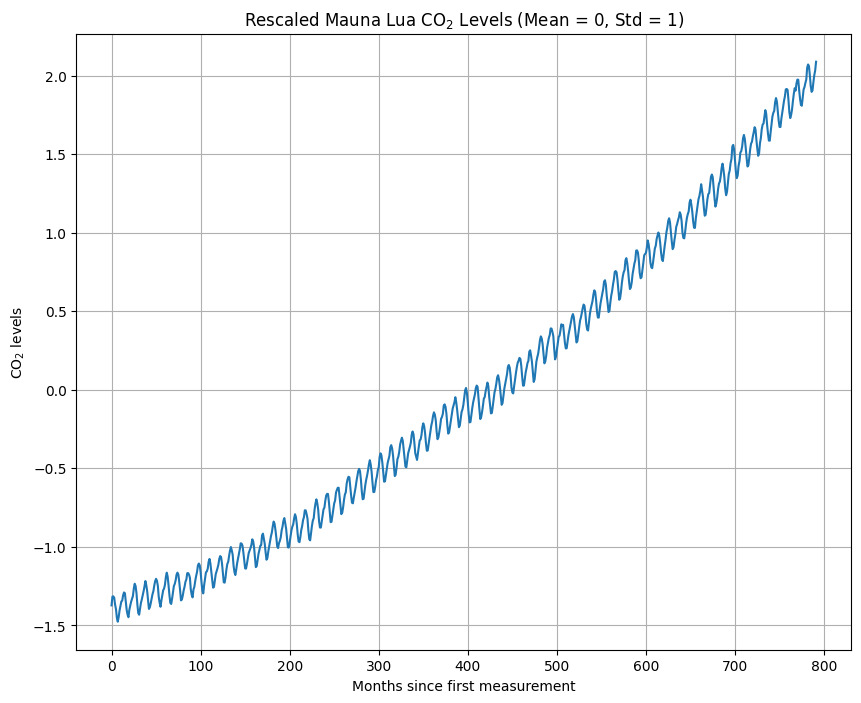

In [21]:
fig = plt.figure(figsize=(10,8))
plt.title(r'Rescaled Mauna Lua CO$_2$ Levels (Mean = 0, Std = 1)')
plt.plot(df.index, scaled_D)
plt.xlabel('Months since first measurement')
plt.ylabel(r'CO$_2$ levels')
plt.grid()
plt.show()

In [254]:
K = 30
T = 10

D = np.zeros(shape=(len(scaled_D)-(K+T)+1, K+T))
for i in range(D.shape[0]):
    D[i] = np.concatenate([scaled_D[i:i+K,0], scaled_D[i+K:i+K+T,0]])
D, D.shape

(array([[-1.3721661 , -1.31653778, -1.31463052, ..., -1.25200892,
         -1.21704255, -1.24279052],
        [-1.31653778, -1.31463052, -1.32321318, ..., -1.21704255,
         -1.24279052, -1.28093565],
        [-1.31463052, -1.32321318, -1.36708008, ..., -1.24279052,
         -1.28093565, -1.3375176 ],
        ...,
        [ 1.67276936,  1.67245148,  1.72394741, ...,  1.90577256,
          1.95790425,  2.0024069 ],
        [ 1.67245148,  1.72394741,  1.75986742, ...,  1.95790425,
          2.0024069 ,  2.03228726],
        [ 1.72394741,  1.75986742,  1.79991981, ...,  2.0024069 ,
          2.03228726,  2.08791558]]),
 (753, 40))

Train Test Split

In [255]:
train_size = 0.80
X_train, X_test, y_train, y_test = D[:int(len(D)*train_size),:K], D[int(len(D)*train_size):,:K], D[:int(len(D)*train_size),K:K+T], D[int(len(D)*train_size):,K:K+T]   
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((602, 30), (602, 10), (151, 30), (151, 10))

In [256]:
X_train = torch.tensor(X_train,dtype = torch.float32, device = device, requires_grad=False)
y_train = torch.tensor(y_train,dtype = torch.float32, device = device, requires_grad=False)
X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
y_test = torch.tensor(y_test,dtype = torch.float32, device = device, requires_grad=False)

Multi Layer Perceptron Model

In [257]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_size1, hidden_size2, output_dim):
    super(MLP, self).__init__()
    self.lin1 = nn.Linear(input_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, output_dim)

  def forward(self, x):
    y1 = self.lin1(x)
    y2 = torch.relu(y1)
    y3 = self.lin2(y2)
    y4 = torch.relu(y3)
    y = self.lin3(y4)
    return y

In [258]:
hidden_size1 = 15
hidden_size2 = 8
model = MLP(input_dim = K, hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, output_dim = T)

In [259]:
model

MLP(
  (lin1): Linear(in_features=30, out_features=15, bias=True)
  (lin2): Linear(in_features=15, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=10, bias=True)
)

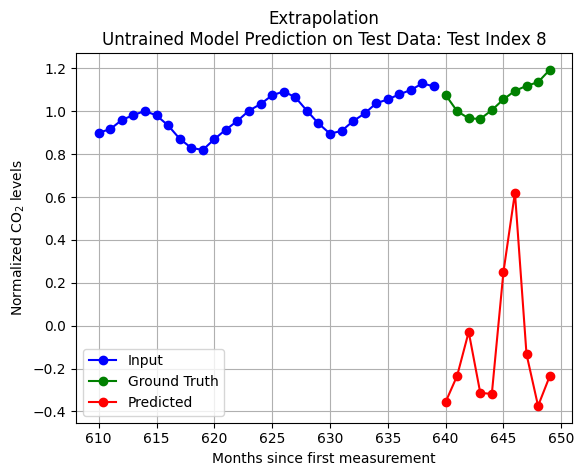

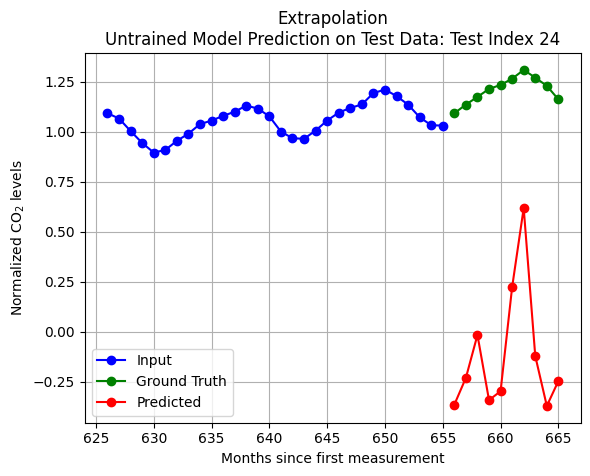

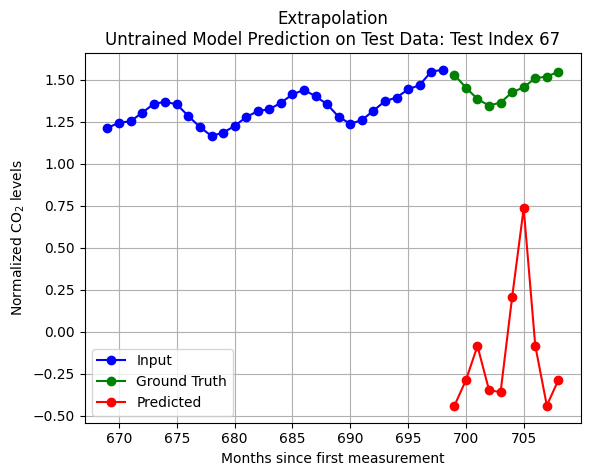

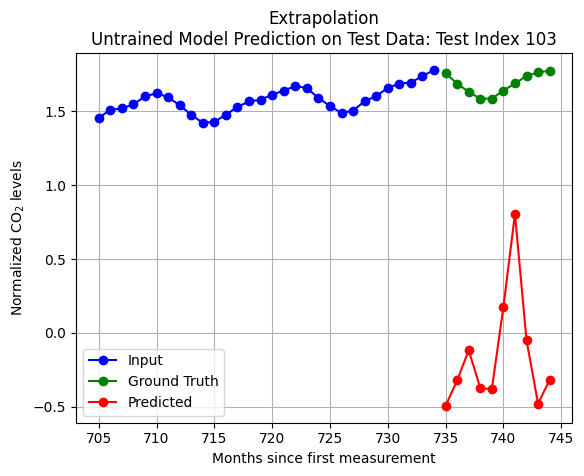

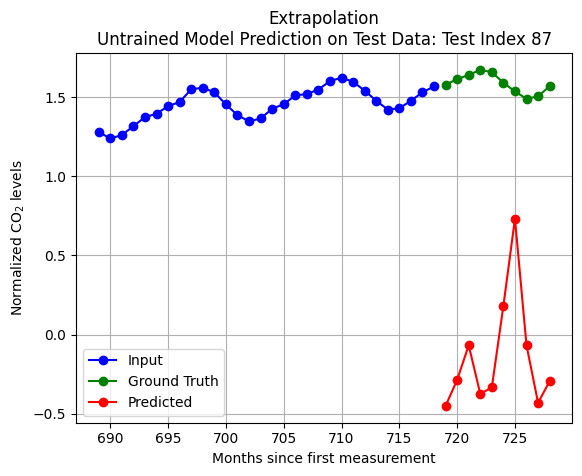

In [261]:
seed = 100
np.random.seed(seed)
with torch.no_grad():
    num_test_cases = 5
    test_indices = np.random.randint(0, len(X_test), size = num_test_cases)
    for i in test_indices:
        y = model(X_test[i])
        plt.title(f'Extrapolation\nUntrained Model Prediction on Test Data: Test Index {i}')
        plt.plot(np.arange(i+len(X_train),i+len(X_train)+K,1), X_test[i], 'bo-')
        plt.plot(np.arange(i+len(X_train)+K,i+len(X_train)+K+T,1), y_test[i].detach().numpy(), 'go-')
        plt.plot(np.arange(i+len(X_train)+K,i+len(X_train)+K+T,1), y.detach().numpy(), 'ro-')
        plt.legend(['Input','Ground Truth','Predicted'])
        plt.xlabel('Months since first measurement')
        plt.ylabel(r'Normalized CO$_2$ levels')
        plt.grid()
        plt.show()

Training the model

In [262]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr = 0.001)
print_every = 100

dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
convergence = 1e-8
losses = []

for epoch in range(2000):
    l = 0
    for data, target in train_dataloader:
        opt.zero_grad()
        y_pred = model(data)
        loss = loss_fn(y_pred, target.reshape(-1,T))

        l += loss.item()

        loss.backward()
        opt.step()
    
    losses.append(l/len(X_train))
    if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
        print(f'Final Training Loss: {losses[-1]}')
        print(f'Converged after {epoch} epochs')
        break

    if epoch % print_every == 0:
        print(f"Epoch: {epoch} | Loss: {losses[-1]}")

Epoch: 0 | Loss: 0.01764713861419513
Epoch: 100 | Loss: 8.325458796651558e-05
Final Training Loss: 2.294826821000176e-05
Converged after 181 epochs


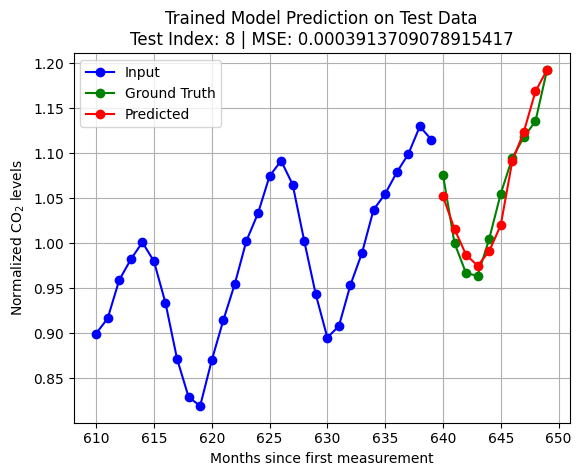

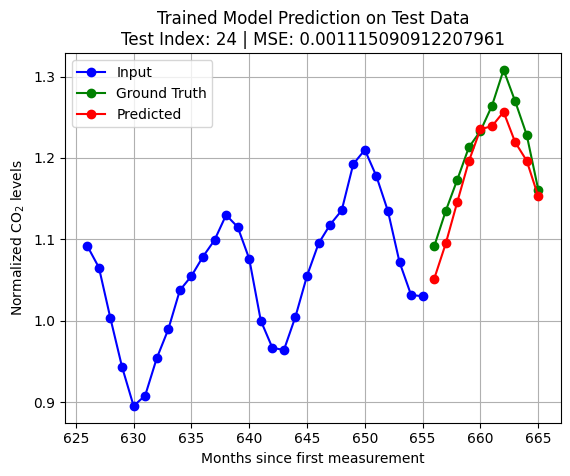

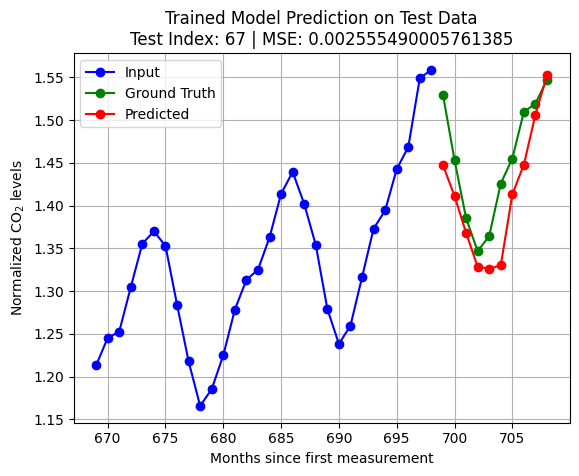

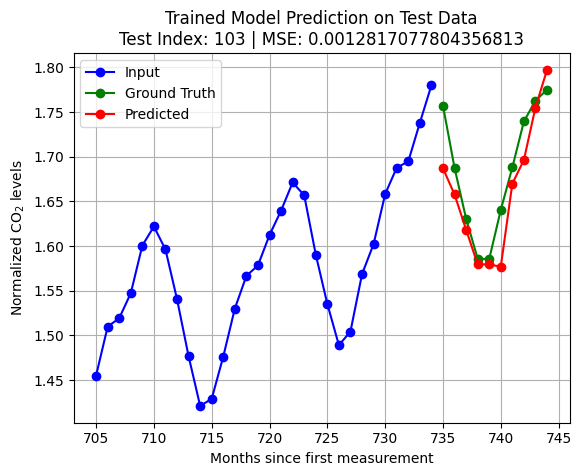

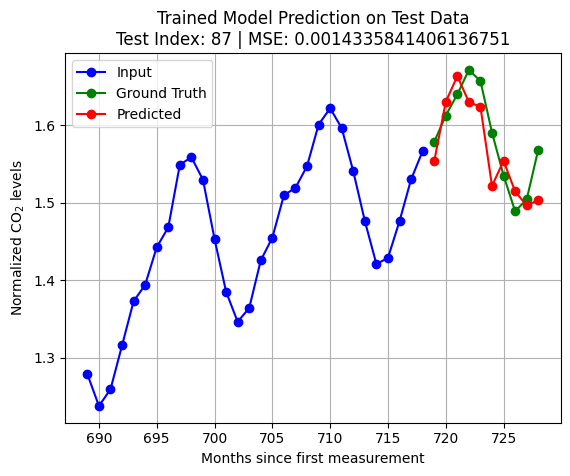

In [263]:
np.random.seed(seed)
with torch.no_grad():
    num_test_cases = 5
    test_indices = np.random.randint(0, len(X_test), size = num_test_cases)
    for i in test_indices:
        y = model(X_test[i])
        loss = loss_fn(y, y_test[i])
        plt.title(f'Trained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
        plt.plot(np.arange(i+len(X_train),i+len(X_train)+K,1), X_test[i], 'bo-')
        plt.plot(np.arange(i+len(X_train)+K,i+len(X_train)+K+T,1), y_test[i].detach().numpy(), 'go-')
        plt.plot(np.arange(i+len(X_train)+K,i+len(X_train)+K+T,1), y.detach().numpy(), 'ro-')
        plt.legend(['Input','Ground Truth','Predicted'])
        plt.xlabel('Months since first measurement')
        plt.ylabel(r'Normalized CO$_2$ levels')
        plt.grid()
        plt.show()